# Goal

Can a classification model determine if a wine is white or red?

Which classification model, if any, works best to classify this data based on these variables?

In [1]:
# Imports

# Data import and manipulation
import pandas as pd

# Math
import numpy as np
# Seeding the whole notebook (although in general I also always set my random
# state manually when it is an option)
np.random.seed(543)

# Some statistics, including some checks for normality and skew
from scipy import stats
from scipy.stats import norm, skew

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
# Prettier visualizations
import seaborn as sns
# Sets the default style for seaborn, adding the nice darkgrid background
sns.set()

In [2]:
# Reading the csv, which already has an index column
df = pd.read_csv("wine-data/winemag-data-130k-v2.csv", index_col=0)

In [3]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Data in the description and designation columns are going to give away what kind of wine it is in many cases. We also are not interested in details about the taster of the wine. Additionally, the region information has a lot of variety but does not give us that much more data than country, province and winery. Thus, we'll remove those columns, as well as the title for each wine, and leave only columns that we hope will work as potential predicters of variety.

In [4]:
data = df.drop(columns=["description", "designation", "region_1", "region_2",
                        "taster_name", "taster_twitter_handle", "title"])

### Exploring the Data

In [5]:
data.head()

,country,points,price,province,variety,winery
0,Italy,87,NaN,Sicily & Sardinia,White Blend,Nicosia
1,Portugal,87,15.0,Douro,Portuguese Red,Quinta dos Avidagos
2,US,87,14.0,Oregon,Pinot Gris,Rainstorm
3,US,87,13.0,Michigan,Riesling,St. Julian
4,US,87,65.0,Oregon,Pinot Noir,Sweet Cheeks


In [6]:
data.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [7]:
data.shape

(129971, 6)

In [8]:
# Checking for nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 6 columns):
country     129908 non-null object
points      129971 non-null int64
price       120975 non-null float64
province    129908 non-null object
variety     129970 non-null object
winery      129971 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 6.9+ MB


In [9]:
len(set(data["variety"]))

708

In [10]:
# Since the top 30 varieties account for more than 80% of our data,
# let's only use observations where the variety is one of those,
# to make it easier to create our target variable, red/white
top_30_variety_counts = data["variety"].value_counts()[:30]
top_30_variety_counts.sum()

105154

In [11]:
top_30_varieties = list(top_30_variety_counts.index)
print(top_30_varieties)

['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend', 'Bordeaux-style Red Blend', 'Riesling', 'Sauvignon Blanc', 'Syrah', 'Rosé', 'Merlot', 'Nebbiolo', 'Zinfandel', 'Sangiovese', 'Malbec', 'Portuguese Red', 'White Blend', 'Sparkling Blend', 'Tempranillo', 'Rhône-style Red Blend', 'Pinot Gris', 'Champagne Blend', 'Cabernet Franc', 'Grüner Veltliner', 'Portuguese White', 'Bordeaux-style White Blend', 'Pinot Grigio', 'Gamay', 'Gewürztraminer', 'Viognier', 'Shiraz']


In [12]:
# Now, let's make our data just those where the variety is one of the top 30
data = data[data["variety"].isin(top_30_varieties)]

In [13]:
data.head()

,country,points,price,province,variety,winery
0,Italy,87,NaN,Sicily & Sardinia,White Blend,Nicosia
1,Portugal,87,15.0,Douro,Portuguese Red,Quinta dos Avidagos
2,US,87,14.0,Oregon,Pinot Gris,Rainstorm
3,US,87,13.0,Michigan,Riesling,St. Julian
4,US,87,65.0,Oregon,Pinot Noir,Sweet Cheeks


In [14]:
# I made the color dictionary by hand for this, to make it easier to see
# which wines are in which category here
# For the curious, I'm considering a Rose a white for simplicity
color = {"red": ["Pinot Noir", "Cabernet Sauvignon", "Red Blend",
                 "Bordeaux-style Red Blend", "Syrah", "Merlot", "Nebbiolo",
                 "Zinfandel", "Sangiovese", "Malbec", "Portuguese Red",
                 "Tempranillo", "Rhône-style Red Blend", "Cabernet Franc",
                 "Gamay", "Shiraz"],
         "white": ["Chardonnay", "Riesling", "Sauvignon Blanc", "Rosé",
                   "White Blend", "Sparkling Blend", "Pinot Gris",
                   "Champagne Blend", "Grüner Veltliner", "Portuguese White",
                   "Bordeaux-style White Blend", "Pinot Grigio",
                   "Gewürztraminer", "Viognier"]}

In [15]:
print(color["red"])
print(color["white"])

['Pinot Noir', 'Cabernet Sauvignon', 'Red Blend', 'Bordeaux-style Red Blend', 'Syrah', 'Merlot', 'Nebbiolo', 'Zinfandel', 'Sangiovese', 'Malbec', 'Portuguese Red', 'Tempranillo', 'Rhône-style Red Blend', 'Cabernet Franc', 'Gamay', 'Shiraz']
['Chardonnay', 'Riesling', 'Sauvignon Blanc', 'Rosé', 'White Blend', 'Sparkling Blend', 'Pinot Gris', 'Champagne Blend', 'Grüner Veltliner', 'Portuguese White', 'Bordeaux-style White Blend', 'Pinot Grigio', 'Gewürztraminer', 'Viognier']


In [16]:
# Creating our new target column, color
def find_color(variety):
    if variety in color["red"]:
        var_color = "red"
    elif variety in color["white"]:
        var_color = "white"
    else:
        var_color = "whoops"
    return var_color
data["color"] = df["variety"].map(lambda x: find_color(x))

In [17]:
# Dropping our variety column, since we no longer need it
data = data.drop(columns="variety")

In [18]:
data.head()

,country,points,price,province,winery,color
0,Italy,87,NaN,Sicily & Sardinia,Nicosia,white
1,Portugal,87,15.0,Douro,Quinta dos Avidagos,red
2,US,87,14.0,Oregon,Rainstorm,white
3,US,87,13.0,Michigan,St. Julian,white
4,US,87,65.0,Oregon,Sweet Cheeks,red


In [19]:
# Our classes are unbalanced, something we should keep in mind later
data["color"].value_counts()

red      65687
white    39467
Name: color, dtype: int64

In [20]:
# Now let's look at our NaNs and datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105154 entries, 0 to 129970
Data columns (total 6 columns):
country     105114 non-null object
points      105154 non-null int64
price       98166 non-null float64
province    105114 non-null object
winery      105154 non-null object
color       105154 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 5.6+ MB


In [21]:
# First things first, let's deal with our nulls
# Only 40 entries, out of over 100,000, are missing country/province data
# So I will drop those, rather than guessing or looking up the winery by hand

data["country"].isna().sum()

40

In [22]:
data.dropna(subset=["country","province"], inplace=True)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105114 entries, 0 to 129970
Data columns (total 6 columns):
country     105114 non-null object
points      105114 non-null int64
price       98130 non-null float64
province    105114 non-null object
winery      105114 non-null object
color       105114 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 5.6+ MB


In [24]:
# We still have a lot of nulls in our price column.
# Rather than removing all of those values, I'll create a new column to track
# which observations were missing price data, then fill the nulls

data['price_missing'] = np.where(np.isnan(data['price']) == True, 1, 0)

In [25]:
# Checking what seems more reasonable, median or mean - median wins
# Mean is more affected by the outliers in our data, which there are several
print(data["price"].median())
print(data["price"].mean())

27.0
36.71797615408132


In [26]:
# Replacing nulls with median price
clean_data = data.copy()
clean_data["price"].fillna(clean_data["price"].median(), inplace=True)

In [27]:
clean_data.head()

,country,points,price,province,winery,color,price_missing
0,Italy,87,27.0,Sicily & Sardinia,Nicosia,white,1
1,Portugal,87,15.0,Douro,Quinta dos Avidagos,red,0
2,US,87,14.0,Oregon,Rainstorm,white,0
3,US,87,13.0,Michigan,St. Julian,white,0
4,US,87,65.0,Oregon,Sweet Cheeks,red,0


In [28]:
# Yay, no more nulls!
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105114 entries, 0 to 129970
Data columns (total 7 columns):
country          105114 non-null object
points           105114 non-null int64
price            105114 non-null float64
province         105114 non-null object
winery           105114 non-null object
color            105114 non-null object
price_missing    105114 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 6.4+ MB


In [29]:
# Our top 10 countries account for more than 95% of our cleaned up, no-null
# data, so let's start with those to build our model
top_10_countries = clean_data["country"].value_counts()[:10]
top_10_countries.sum()

101085

In [30]:
top_10_countries = list(top_10_countries.index)
# Now, let's make our data just those where the variety is one of the top 30
clean_data = clean_data[clean_data["country"].isin(top_10_countries)]

## Initial, Baseline Classification Model - Logistic Regression

Let's build an initial, baseline model and see if it can predict whether a wine is white or red!

In [31]:
# Let's go ahead and remove our target variable
init_data = clean_data.copy()
target = init_data["color"]
init_data = init_data.drop(columns="color")

In [32]:
# While we can use more than one variable, our logistic regression model is
# not going to like our categorical variables, so let's just put in our 
# continuous variables, points and price
X = init_data[["points", "price"]]

In [33]:
# Create a train-test split, so we reserve some data for testing
from sklearn.model_selection import train_test_split

X_init_train, X_init_test, y_init_train, y_init_test = train_test_split(
    X, target, test_size=.25, random_state=543)

In [34]:
# Since our problem is binary, let's start with logistic regression 
from sklearn.linear_model import LogisticRegression

# Starting with just out-of-the box setting, meaning I'm not playing around
# with class weight just yet even though I know they're unbalanced
logreg = LogisticRegression(solver="lbfgs", random_state=543)

logreg.fit(X_init_train, y_init_train)
log_preds = logreg.predict(X_init_test)

In [35]:
# Really quick, let's define some functions so we can check how each of our
# classification modesl are doing

# Extra imports, for metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# unique_label allows the confusion matrix to automatically label itself
from sklearn.utils.multiclass import unique_labels

# Visualizing a confusion matrix
def vis_cm(y_true, y_pred):
    # Takes true values first, then predicted values
    c_mat = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    # Visualizes the matrix
    sns.heatmap(c_mat, annot=True, cmap=plt.cm.Blues, fmt='g')

    # Adds title and axis labels
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Adds appropriate axis scales
    class_names = unique_labels(y_true, y_pred)
    tick_marks = np.arange(len(class_names))
    # The +.5 here just centers the labels, red or white, since it's 2x2
    plt.xticks(tick_marks + .5, class_names)
    plt.yticks(tick_marks + .5, class_names)

    plt.show()

def print_scores(model, X_train, X_test, y_train, y_test, y_pred):
    print("Training Accuracy: {}".format(model.score(X_train, y_train)))
    print("Testing Accuracy: {}".format(model.score(X_test, y_test)))
    print(classification_report(y_test, y_pred))

Training Accuracy: 0.6314484323269096
Testing Accuracy: 0.62278410889522


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         red       0.62      1.00      0.77     15739
       white       0.00      0.00      0.00      9533

   micro avg       0.62      0.62      0.62     25272
   macro avg       0.31      0.50      0.38     25272
weighted avg       0.39      0.62      0.48     25272



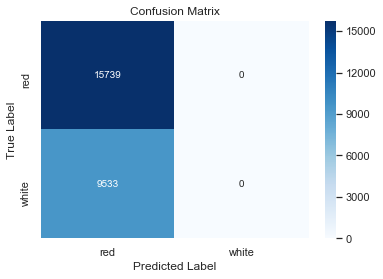

In [36]:
print_scores(logreg, X_init_train, X_init_test,
             y_init_train, y_init_test, log_preds)
vis_cm(y_init_test, log_preds)

WOW what a terrible model, it just predicted everything was red for both our training and testing data it seems. Whelp. Perhaps it's because our classes are so unbalanced, let's fix that.

In [37]:
# Balancing our classes within the Logistic Regression
logreg_balanced = LogisticRegression(class_weight="balanced", 
                                     solver="lbfgs", 
                                     random_state=543)

logreg_balanced.fit(X_init_train, y_init_train)
log_balanced_preds = logreg_balanced.predict(X_init_test)

Training Accuracy: 0.5731602759421207
Testing Accuracy: 0.5809195948084837
              precision    recall  f1-score   support

         red       0.78      0.46      0.58     15739
       white       0.47      0.78      0.58      9533

   micro avg       0.58      0.58      0.58     25272
   macro avg       0.62      0.62      0.58     25272
weighted avg       0.66      0.58      0.58     25272



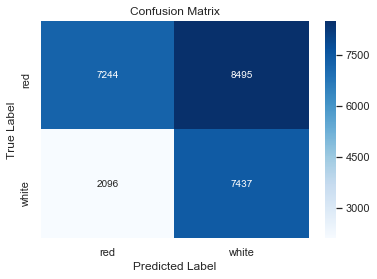

In [38]:
print_scores(logreg_balanced, X_init_train, X_init_test, y_init_train,
             y_init_test, log_balanced_preds)
vis_cm(y_init_test, log_balanced_preds)

So this model scored worse, but at least it wasn't only guessing red and actually tried to predict red or white. Looks like we have a lot more work to do to get to a place where a logistic regression model can use our data. So let's work on that, before moving on to any other kind of model.

## Further Data Cleaning

In [39]:
clean_data.head()

,country,points,price,province,winery,color,price_missing
0,Italy,87,27.0,Sicily & Sardinia,Nicosia,white,1
1,Portugal,87,15.0,Douro,Quinta dos Avidagos,red,0
2,US,87,14.0,Oregon,Rainstorm,white,0
3,US,87,13.0,Michigan,St. Julian,white,0
4,US,87,65.0,Oregon,Sweet Cheeks,red,0


In [40]:
# Let's go ahead and once again take out our target variable, color
y = clean_data["color"]
clean_data.drop(columns="color", inplace=True)

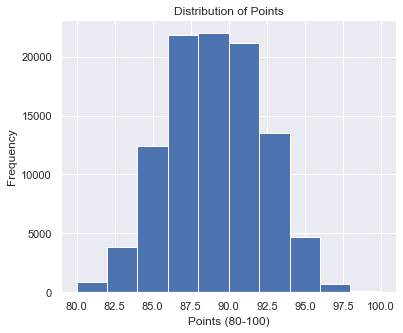

In [41]:
# Checking out the distribution of our 'points' variable - fairly normal
plt.figure(figsize=(6,5))
plt.hist(clean_data["points"])
plt.title("Distribution of Points")
plt.xlabel("Points (80-100)")
plt.ylabel("Frequency")
plt.show()

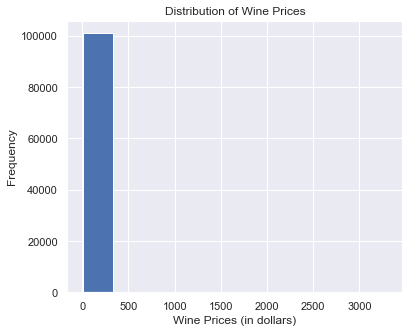

In [42]:
# Checking out the distribution of our 'price' variable - not normal at all!
plt.figure(figsize=(6,5))
plt.hist(clean_data["price"])
plt.title("Distribution of Wine Prices")
plt.xlabel("Wine Prices (in dollars)")
plt.ylabel("Frequency")
plt.show()

In [43]:
logged_data = clean_data.copy()
logged_data["log_price"] = np.log1p(logged_data["price"])

In [44]:
logged_data.head()

,country,points,price,province,winery,price_missing,log_price
0,Italy,87,27.0,Sicily & Sardinia,Nicosia,1,3.332205
1,Portugal,87,15.0,Douro,Quinta dos Avidagos,0,2.772589
2,US,87,14.0,Oregon,Rainstorm,0,2.708050
3,US,87,13.0,Michigan,St. Julian,0,2.639057
4,US,87,65.0,Oregon,Sweet Cheeks,0,4.189655


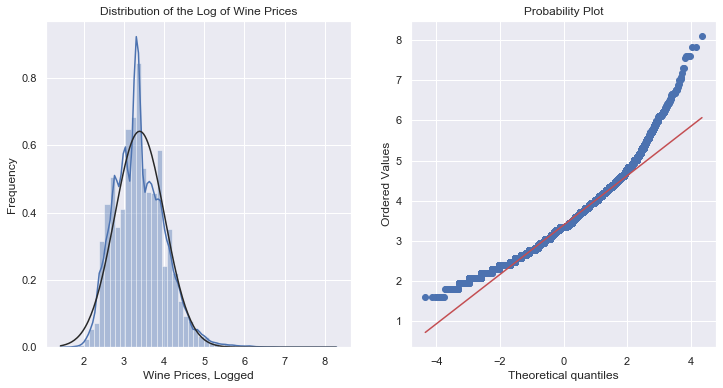

In [45]:
# Plotting a distribution plot, plus a Q-Q plot to check skew
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

# By setting fit=norm, we can better compare to a normal distribution
sns.distplot(logged_data["log_price"], fit=norm, ax=ax1)
stats.probplot(logged_data["log_price"], plot=ax2)

ax1.set_title("Distribution of the Log of Wine Prices")
ax1.set(xlabel="Wine Prices, Logged", ylabel="Frequency")

plt.show()
# Without removing any outliers, logging the price makes it more normal,
# although it's still skewed. Should be good enough for now, but may want
# to revisit and check outliers later.

In [46]:
# Because the log of price is more normal, for the rest of the analysis we'll
# drop the actual price and our indicator column, price_missing

logged_data.drop(columns=["price", "price_missing"], inplace=True)

In [47]:
# Now, let's deal with our categorical variables
# There are too many unique entries in each of our categorical columns, so
# instead we'll simply label encode each using sklearn

from sklearn.preprocessing import LabelEncoder
labeler = LabelEncoder()

logged_data["country"] = labeler.fit_transform(
    logged_data["country"].astype(str))
logged_data["province"] = labeler.fit_transform(
    logged_data["province"].astype(str))
logged_data["winery"] = labeler.fit_transform(
    logged_data["winery"].astype(str))

# Note! We've done nothing to associate nearby countries with each other
# We'll see how this does, and maybe will have to do some kind of sorting
# later on if this does not produce the results we want
logged_data.head()

,country,points,province,winery,log_price
0,6,87,135,9818,3.332205
1,7,87,48,10908,2.772589
2,9,87,108,10959,2.708050
3,9,87,86,12081,2.639057
4,9,87,108,12271,4.189655


In [48]:
# All of our variables are on VASTLY different scales, so let's scale them 
# all to be between zero and one
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(logged_data)
scaled_data = pd.DataFrame(scaled_data, columns=logged_data.columns)
scaled_data.head()

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,country,points,province,winery,log_price
0,0.666667,0.35,0.767045,0.702490,0.265345
1,0.777778,0.35,0.272727,0.780481,0.179152
2,1.000000,0.35,0.613636,0.784130,0.169211
3,1.000000,0.35,0.488636,0.864410,0.158585
4,1.000000,0.35,0.613636,0.878005,0.397412


In [49]:
scaled_data.describe()

,country,points,province,winery,log_price
count,101085.000000,101085.000000,101085.000000,101085.000000,101085.000000
mean,0.739389,0.427700,0.403967,0.523867,0.274762
std,0.299422,0.155447,0.302563,0.289150,0.095798
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.444444,0.300000,0.159091,0.299227,0.205621
50%,0.888889,0.400000,0.215909,0.545578,0.265345
75%,1.000000,0.550000,0.647727,0.774614,0.338423
max,1.000000,1.000000,1.000000,1.000000,1.000000


[]

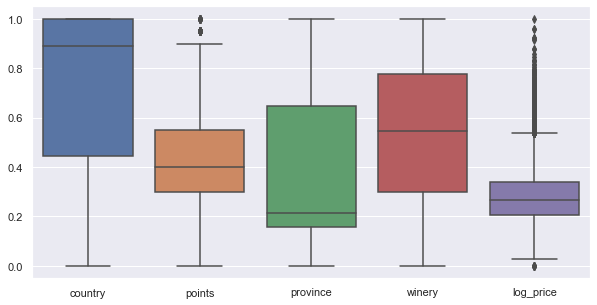

In [50]:
# Checking out the distributions, via boxplots
plt.figure(figsize=(10,5))
sns.boxplot(data=scaled_data)
plt.plot()

In [51]:
# Creating a correlation df to investigate correlation between variables
map_corr = np.corrcoef(scaled_data, rowvar=False)

In [52]:
# Prepping the correlation dataframe to be visualized
map_corr = pd.DataFrame(map_corr,
                        columns=scaled_data.columns,
                        index=scaled_data.columns)

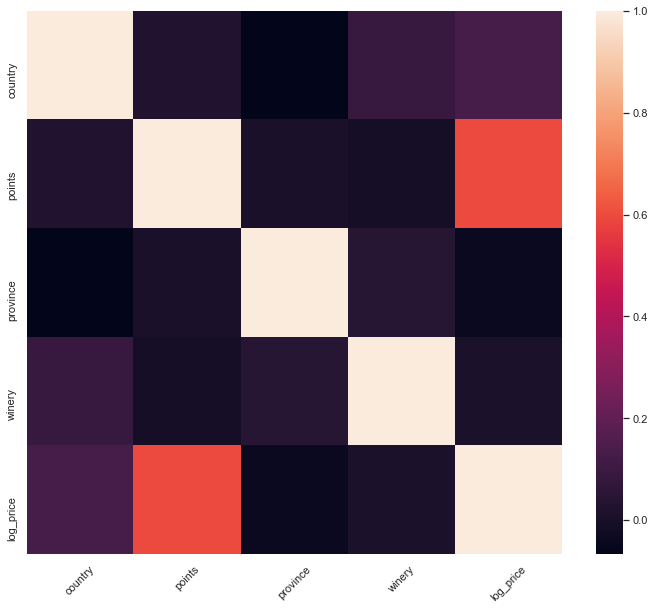

In [53]:
# Plotting the correlation between variables - shouldn't surprise us that 
# price and points are correlated. The rest aren't particularly correlated
plt.figure(figsize=(12,10))
ax = sns.heatmap(data = map_corr)
plt.xticks(rotation=45) 
plt.show()

In [54]:
# Need a new train/test split

X_train, X_test, y_train, y_test = train_test_split(
    scaled_data, y, test_size=.25, random_state=543)

In [55]:
# Now let's try another logistic regression model on this data!
logreg_scaled = LogisticRegression(class_weight="balanced",
                                   solver="lbfgs",
                                   random_state=543)

logreg_scaled.fit(X_train, y_train)
log_scaled_preds = logreg_scaled.predict(X_test)

Training Accuracy: 0.6266999063485155
Testing Accuracy: 0.6320829376384932
              precision    recall  f1-score   support

         red       0.75      0.62      0.68     15739
       white       0.51      0.65      0.57      9533

   micro avg       0.63      0.63      0.63     25272
   macro avg       0.63      0.64      0.62     25272
weighted avg       0.66      0.63      0.64     25272



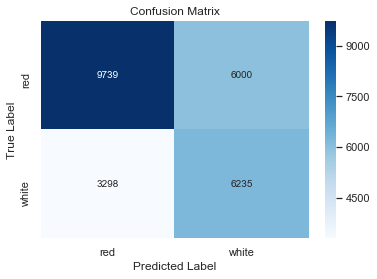

In [56]:
print_scores(logreg_scaled, X_train, X_test, y_train, y_test, log_scaled_preds)
vis_cm(y_test, log_scaled_preds)

So our model improved for sure, back up to 62% accuracy, but it's not great. We could further play around with the parameters within this model, but let's try a different type of model - the answer might be that a logistic regression model may not be the best bet for this data.

## Next Step - Decision Trees

In [57]:
from sklearn.tree import DecisionTreeClassifier

# Once again, just using the out-of-the-box default settings
dec_tree = DecisionTreeClassifier(random_state=543)

dec_tree.fit(X_train, y_train)
tree_preds = dec_tree.predict(X_test)

Training Accuracy: 0.9804650917388839
Testing Accuracy: 0.7809037670148782
              precision    recall  f1-score   support

         red       0.82      0.84      0.83     15739
       white       0.72      0.69      0.70      9533

   micro avg       0.78      0.78      0.78     25272
   macro avg       0.77      0.76      0.77     25272
weighted avg       0.78      0.78      0.78     25272



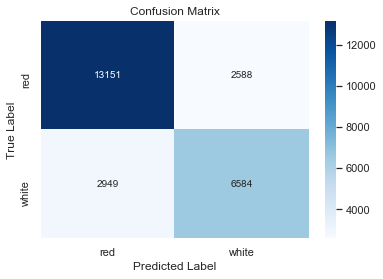

In [58]:
print_scores(dec_tree, X_train, X_test, y_train,
             y_test, tree_preds)
vis_cm(y_test, tree_preds)

Better than our logistic regression model! But, look at the difference between our training and testing mean accuracy scores - we can tell our model is really overfit. We can fix this by adjusting some of the hyperparameters that go into our decision tree model.

In [59]:
# Let's do a grid search! These are only as good as the parameters we put in
# the grid to test, but it'll certainly give us some direction
from sklearn.model_selection import GridSearchCV

# Let's try different options for criterion, max_depth and min_samples_split,
# and also test whether the class imbalance between red and white is affecting
# our results by balancing our class_weight
param_grid_tree = {
    "criterion": ["gini", "entropy"],
    "max_depth": range(1,10),
    "min_samples_split": range(2,10),
    "class_weight": [None, "balanced"]
}

gs_tree = GridSearchCV(dec_tree, param_grid_tree, cv=3)
gs_tree.fit(X_train, y_train)

# By calling best_params_, this model will tell us what had the best results
# Note that this will simply use dec_tree.score, which gives mean accuracy
gs_tree.best_params_

# Warning, running this can take a few minutes

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'min_samples_split': 3}

Training Accuracy: 0.7559257647105377
Testing Accuracy: 0.7459243431465654
              precision    recall  f1-score   support

         red       0.79      0.80      0.80     15739
       white       0.67      0.66      0.66      9533

   micro avg       0.75      0.75      0.75     25272
   macro avg       0.73      0.73      0.73     25272
weighted avg       0.75      0.75      0.75     25272



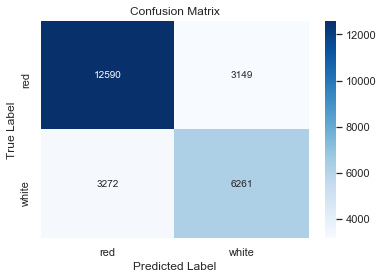

In [59]:
grid_tree = DecisionTreeClassifier(criterion="gini",
                                   max_depth=9,
                                   min_samples_split=3,
                                   class_weight=None,
                                   random_state=543)

grid_tree.fit(X_train, y_train)
grid_tree_preds = grid_tree.predict(X_test)

print_scores(grid_tree, X_train, X_test, y_train,
             y_test, grid_tree_preds)
vis_cm(y_test, grid_tree_preds)

Much more balanced between training and testing data! It's not a perfect model, by any stretch, but we've overcome our overfitting problem and have improved upon our logistic regression models.

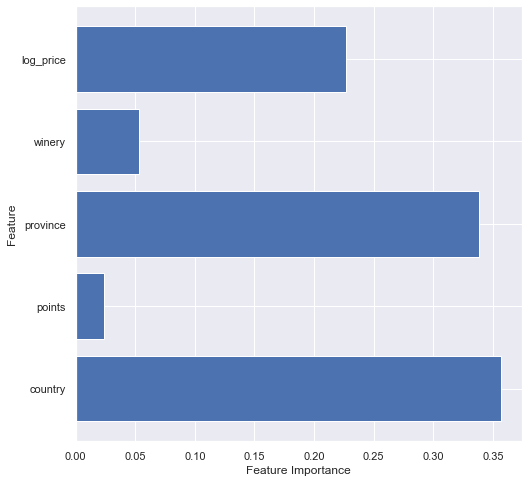

In [60]:
# Let's just check which features are important for this single tree

# This function was taken from learn.co, and visualizes a model's 
# .feature_importances_ attribute in order to see what's used to predict color
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.show()

plot_feature_importances(grid_tree)

## Random Forests

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Accuracy: 0.9659161357550816
Testing Accuracy: 0.7883428300094967
              precision    recall  f1-score   support

         red       0.81      0.86      0.84     15739
       white       0.75      0.67      0.70      9533

   micro avg       0.79      0.79      0.79     25272
   macro avg       0.78      0.76      0.77     25272
weighted avg       0.79      0.79      0.79     25272



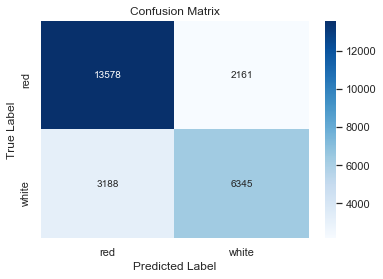

In [61]:
# Let's jump straight in and train a random forest model!
from sklearn.ensemble import RandomForestClassifier

# As usual, let's run it on default settings first
ran_forest = RandomForestClassifier(random_state=543)

ran_forest.fit(X_train, y_train)
ran_for_preds = ran_forest.predict(X_test)

print_scores(ran_forest, X_train, X_test, y_train,
             y_test, ran_for_preds)
vis_cm(y_test, ran_for_preds)

Predictably, like with our out-of-the-box decision tree, this model is overfit - pretty big difference between training and testing accuracy. So let's do another grid search!

Training Accuracy: 0.7039294052471212
Testing Accuracy: 0.7051282051282052
              precision    recall  f1-score   support

         red       0.84      0.65      0.73     15739
       white       0.58      0.80      0.67      9533

   micro avg       0.71      0.71      0.71     25272
   macro avg       0.71      0.72      0.70     25272
weighted avg       0.74      0.71      0.71     25272



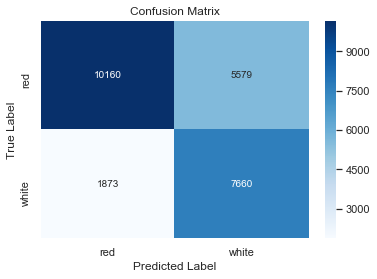

In [62]:
# Now let's try with some arbitrary hyperparameters, just guessing
arb_ran_forest = RandomForestClassifier(n_estimators=100,
                                        max_depth=5,
                                        min_samples_split=3,
                                        class_weight="balanced_subsample",
                                        random_state=543)

arb_ran_forest.fit(X_train, y_train)
arb_for_preds = arb_ran_forest.predict(X_test)

print_scores(arb_ran_forest, X_train, X_test, y_train,
             y_test, arb_for_preds)
vis_cm(y_test, arb_for_preds)

Yikes, it got worse - although no longer as overfit. Well, just proves that we should run a gridsearch for hyperparameters, rather than guessing at random.

In [ ]:
# Setting some hyperparameters to test. Rather than using ranges, like I did
# for the decision tree, I chose some at random just to test (otherwise this
# would take even longer to run)
param_grid_forest = {
    "n_estimators": [10, 100],
    "max_depth": [1, 3, 5, 9],
    "min_samples_split": [2, 3, 5],
    "class_weight": [None, "balanced", "balanced_subsample"]
}

gs_forest = GridSearchCV(ran_forest, param_grid_forest, cv=3)
gs_forest.fit(X_train, y_train)

gs_forest.best_params_

# Warning, running this will take more than a few minutes

Training Accuracy: 0.7800377244008283
Testing Accuracy: 0.7668170307059196
              precision    recall  f1-score   support

         red       0.78      0.87      0.82     15739
       white       0.73      0.60      0.66      9533

   micro avg       0.77      0.77      0.77     25272
   macro avg       0.76      0.73      0.74     25272
weighted avg       0.76      0.77      0.76     25272



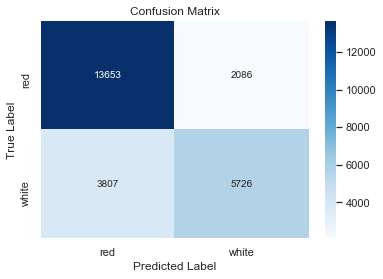

In [63]:
grid_forest = RandomForestClassifier(n_estimators=100, 
                                     max_depth=9, 
                                     min_samples_split=2, 
                                     class_weight=None, 
                                     random_state=543)

grid_forest.fit(X_train, y_train)
grid_for_preds = grid_forest.predict(X_test)

print_scores(grid_forest, X_train, X_test, y_train,
             y_test, grid_for_preds)
vis_cm(y_test, grid_for_preds)

So this was a slight improvement over a single decision tree, but only about a 2% increase in testing accuracy was probably not worth the 10 minute grid search I ran. But at least the model isn't overfit like before?

## K-Nearest Neighbors

Training Accuracy: 0.8371123685911387
Testing Accuracy: 0.7535216840772396
              precision    recall  f1-score   support

         red       0.79      0.83      0.81     15739
       white       0.69      0.62      0.66      9533

   micro avg       0.75      0.75      0.75     25272
   macro avg       0.74      0.73      0.73     25272
weighted avg       0.75      0.75      0.75     25272



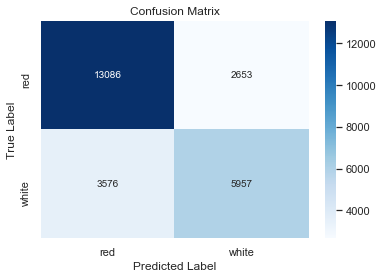

In [64]:
# Let's try a completely different model type and see how it does!
from sklearn.neighbors import KNeighborsClassifier

# Completely basic settings here
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)


print_scores(knn, X_train, X_test, y_train,
             y_test, knn_preds)
vis_cm(y_test, knn_preds)

Slightly overfit but not a bad model overall! Let's try to find a better number for the number of neighbors, k.

In [ ]:
# Let's try a grid search that's just looking for the best number for k

param_grid_knn = {
        "n_neighbors": range(1,20)
}

gs_knn = GridSearchCV(knn, param_grid_knn, cv=3)
gs_knn.fit(X_train, y_train)

# Takes a minute but not nearly as long as the last one
gs_knn.best_params_

Training Accuracy: 0.8030944560959202
Testing Accuracy: 0.757162076606521
              precision    recall  f1-score   support

         red       0.76      0.88      0.82     15739
       white       0.74      0.55      0.63      9533

   micro avg       0.76      0.76      0.76     25272
   macro avg       0.75      0.72      0.72     25272
weighted avg       0.75      0.76      0.75     25272



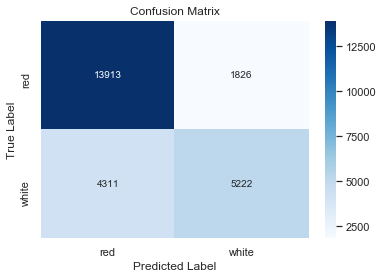

In [67]:
grid_knn = KNeighborsClassifier(n_neighbors=10)

grid_knn.fit(X_train, y_train)
grid_knn_preds = grid_knn.predict(X_test)


print_scores(grid_knn, X_train, X_test, y_train,
             y_test, grid_knn_preds)
vis_cm(y_test, grid_knn_preds)

A little less overfit but still not a great model. It was worth a try.

## Adaptive Boosting, Gradient Boosting, and XGBoost

Training Accuracy: 0.7300199174284093
Testing Accuracy: 0.7205998733776512
              precision    recall  f1-score   support

         red       0.72      0.89      0.80     15739
       white       0.71      0.44      0.54      9533

   micro avg       0.72      0.72      0.72     25272
   macro avg       0.72      0.66      0.67     25272
weighted avg       0.72      0.72      0.70     25272



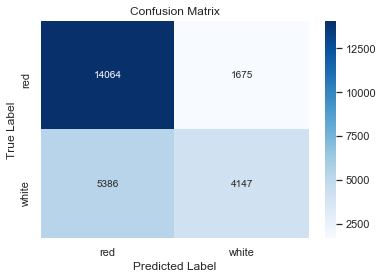

In [68]:
# Now let's try some boosted models, another type ensemble method (like
# random forests) but this time the process is more iterative
# Starting with adaptive boosting, AdaBoost
from sklearn.ensemble import AdaBoostClassifier

# Default settings here - meaning the base estimator it's using is a 
# decision tree classifier with a max depth of one
ada = AdaBoostClassifier(random_state=543)

ada.fit(X_train, y_train)
ada_preds = ada.predict(X_test)

print_scores(ada, X_train, X_test, y_train,
             y_test, ada_preds)
vis_cm(y_test, ada_preds)

Not a great model, but not worse and does not appear to be at all overfit.

Training Accuracy: 0.7685093585532824
Testing Accuracy: 0.76218740107629
              precision    recall  f1-score   support

         red       0.77      0.89      0.82     15739
       white       0.75      0.56      0.64      9533

   micro avg       0.76      0.76      0.76     25272
   macro avg       0.76      0.72      0.73     25272
weighted avg       0.76      0.76      0.75     25272



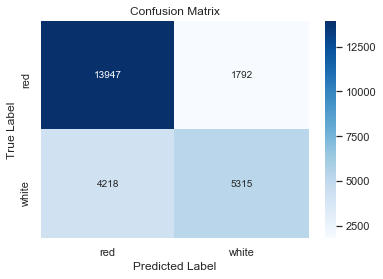

In [69]:
# Now let's try a gradient boosted model, which minimizes a loss function 
# iteratively as opposed to AdaBoost, which uses weighted data points to focus
# on hard-to-classify parts of the model
from sklearn.ensemble import GradientBoostingClassifier

# Default settings: 
grad = GradientBoostingClassifier(random_state=543)

grad.fit(X_train, y_train)
grad_preds = grad.predict(X_test)

print_scores(grad, X_train, X_test, y_train,
             y_test, grad_preds)
vis_cm(y_test, grad_preds)

Better than the AdaBoost model, and appears to have almost no overfitting - testing and training accuracy scores are almost the same, so that's good!

Training Accuracy: 0.768034505955443
Testing Accuracy: 0.7614751503640392
              precision    recall  f1-score   support

         red       0.77      0.88      0.82     15739
       white       0.74      0.56      0.64      9533

   micro avg       0.76      0.76      0.76     25272
   macro avg       0.76      0.72      0.73     25272
weighted avg       0.76      0.76      0.75     25272



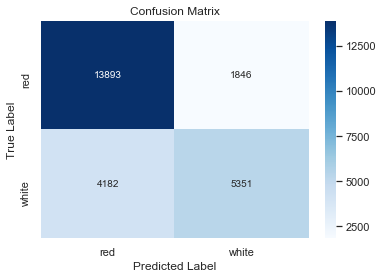

In [70]:
# Now on to XGBoost - which is not in the sklearn library but mirrors its
# structure luckily
import xgboost as xgb

xgb_model = xgb.XGBClassifier(seed=543)
xgb_model.fit(X_train, y_train)

xgb_model_preds = xgb_model.predict(X_test)

print_scores(xgb_model, X_train, X_test, y_train,
             y_test, xgb_model_preds)
vis_cm(y_test, xgb_model_preds)

Looks like it got pretty similar results to the gradient boosted model, to be honest. Let's try to grid search some better hyperparameters for it.

In [79]:
# Setting some parameters to test
param_grid_xgb = {
    "learning_rate": [.1, .3, .6],
    'max_depth': [1, 6],
    'subsample': [0.5, 1],
    'n_estimators': [10, 50, 100],
}

gs_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3)
gs_xgb.fit(X_train, y_train)

# Surprise, surpise, this part is slow
gs_xgb.best_params_

{'learning_rate': 0.6, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1}

Training Accuracy: 0.8353712423990608
Testing Accuracy: 0.790954415954416
              precision    recall  f1-score   support

         red       0.80      0.88      0.84     15739
       white       0.76      0.64      0.70      9533

   micro avg       0.79      0.79      0.79     25272
   macro avg       0.78      0.76      0.77     25272
weighted avg       0.79      0.79      0.79     25272



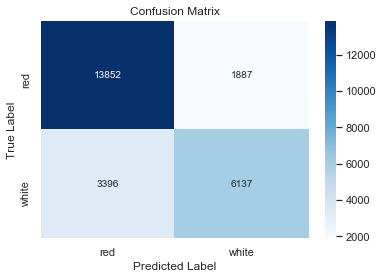

In [71]:
# Righto! Let's plug those parameters in

grid_xgb = xgb.XGBClassifier(learning_rate=.6,
                             max_depth=6,
                             subsample=1,
                             n_estimators=100,
                             seed=543)

grid_xgb.fit(X_train, y_train)
grid_xgb_preds = grid_xgb.predict(X_test)

print_scores(grid_xgb, X_train, X_test, y_train,
             y_test, grid_xgb_preds)
vis_cm(y_test, grid_xgb_preds)

Ooh! This might be our best model yet! But it's still not perfect, far from it - it may be slightly overfit and is still unable to predict a lot of the data.

## Support Vector Machines

Training Accuracy: 0.7174758946354847
Testing Accuracy: 0.7103909465020576
              precision    recall  f1-score   support

         red       0.72      0.86      0.79     15739
       white       0.67      0.46      0.54      9533

   micro avg       0.71      0.71      0.71     25272
   macro avg       0.70      0.66      0.67     25272
weighted avg       0.70      0.71      0.70     25272



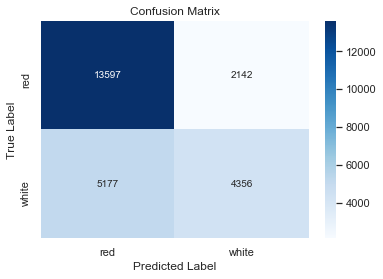

In [72]:
# Let's try one more type of model - a support vector machine (SVM)
from sklearn import svm

# Out-of-the-box settings, meaning a radial basis function (rbf) kernel
# Explicitly setting gamma='scale' to avoid a depreciation warning
sv_clf = svm.SVC(gamma='scale',
                 random_state=543)

sv_clf.fit(X_train, y_train)
svc_preds = sv_clf.predict(X_test)

print_scores(sv_clf, X_train, X_test, y_train,
             y_test, svc_preds)
vis_cm(y_test, svc_preds)

Not our best model, nor our worst. 

I am not going to gridsearch hyperparameters for this, it would be way too slow, but I am going to try a linear SVC to see how it performs.

Training Accuracy: 0.6210676269241423
Testing Accuracy: 0.615068059512504
              precision    recall  f1-score   support

         red       0.64      0.86      0.74     15739
       white       0.48      0.21      0.29      9533

   micro avg       0.62      0.62      0.62     25272
   macro avg       0.56      0.53      0.51     25272
weighted avg       0.58      0.62      0.57     25272



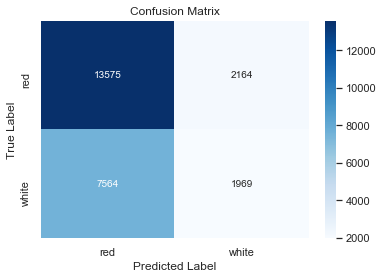

In [73]:
# Employing a linear SVC model, with typical default settings, meaning the 
# penalty type is L2. Using LinearSVC rather than changing the SVC kernel
# because it is much faster
svc_lin = svm.LinearSVC(random_state=543)

svc_lin.fit(X_train, y_train)
svc_lin_preds = svc_lin.predict(X_test)

print_scores(svc_lin, X_train, X_test, y_train,
             y_test, svc_lin_preds)
vis_cm(y_test, svc_lin_preds)

Oh dear, that's a much worse model than we had been seeing. Let's stick with RBF then, for our final comparison.

## Final Results

Now, rather than scrolling through everything, let's iterate over all of our models and see which one ultimately was the most accurate.

In [74]:
# Making a list and a dictionary of each of our models, for iteration
model_list = [logreg_scaled, grid_tree, grid_forest, grid_knn, 
              ada, grad, grid_xgb, sv_clf]
model_dict = {0: 'Logistic Regression',
              1: 'Decision Tree',
              2: 'Random Forest',
              3: 'K-Nearest Neighbors',
              4: 'Adaptive Boosting', 
              5: 'Gradient Boosting', 
              6: 'XGBoost', 
              7: 'Support Vector Machine (RBF)'}

The code below was inspired by a KDNuggets [blog post about pipelines](https://www.kdnuggets.com/2017/12/managing-machine-learning-workflows-scikit-learn-pipelines-part-1.html), even if I worked through each model individually rather than implementing sklearn's pipelines for this project.

In [75]:
# Printing out each model's accuracy
for idx, val in enumerate(model_list):
    print("{} test accuracy: {}".format(model_dict[idx], val.score(X_test, y_test)))

# Identify the most accurate model on test data
best_acc = 0.0
best_clf = 0
best_model = ''
for idx, val in enumerate(model_list):
    if val.score(X_test, y_test) > best_acc:
        best_acc = val.score(X_test, y_test)
        best_model = val
        best_clf = idx
print('Classifier with the best accuracy: %s' % model_dict[best_clf])

Logistic Regression test accuracy: 0.6320829376384932
Decision Tree test accuracy: 0.7459243431465654
Random Forest test accuracy: 0.7668170307059196
K-Nearest Neighbors test accuracy: 0.757162076606521
Adaptive Boosting test accuracy: 0.7205998733776512
Gradient Boosting test accuracy: 0.76218740107629
XGBoost test accuracy: 0.790954415954416
Support Vector Machine (RBF) test accuracy: 0.7103909465020576
Classifier with the best accuracy: XGBoost


And there you have it! Our results, all in one place - looks like the XGBoosted model was the strongest performer on our testing data in terms of accuracy, so any further work to refine this model should focus on using the XGBoosted model. We did a grid search in order to tune some of the XGBoosted model's hyperparameters, but could likely do more work to arrive at more highly tuned parameters. Also, further work could be done with feature selection and interactions before even fitting and running an XGBoosted model. I've split out the XGBoosted model and a bit of additional work [here](https://github.com/lindseyberlin/Mod5Project/blob/master/Lindsey_FinalModel.ipynb).

Additionally, there is always the possibility that a 79% testing accuracy is as good as we're going to get with the data we have - you may not be able to predict a wine's color based on where it came from, its price and its score from a sommelier! 